In [1]:
from post_processing.cleaning.graph_cleaning import graph_cleaning, graph_merging
from post_processing.cleaning.direct_cleaning import direct_cleaning
from post_processing.merging.direct_merging import direct_merging
from post_processing.cleaning.coverage_cleaning import coverage_cleaning
from analyse.validation import calc_characteristics
from ml_notebook.neural_net import cluster_and_neural_net, create_model
from matplotlib import pyplot as plt
from copy import deepcopy
from data_processing.parse_data import *
from time import time
import pandas as pd
import matplotlib
import os

# Create variables for analysis

In [8]:
path = "../../data/tracks_data/"
event_list = os.listdir(path)
cleaning_type_list = ["raw",
                      "direct_cleaning",
                      "direct_merging",
                      "graph_cleaning",
                      "graph_merging",
                      "coverage_cleaning",
                      "cluster_and_neural_net"]

cleaning_func_list = [list,
                      direct_cleaning,
                      direct_merging,
                      graph_cleaning,
                      graph_merging,
                      coverage_cleaning,
                      cluster_and_neural_net]

plot_title = ["Efficiency",
              "Number of tracks left",
              "Fake rate",
              "Duplicates",
              "Purity"]

# Create data objects for information storing

In [9]:
event_list = [event_list[i:i + 3] for i in range(0, len(event_list), 3)]
event_list = sorted(event_list, key=lambda x: int(x[0].split("_")[1]))
df_time = pd.DataFrame(columns=cleaning_type_list)
df_num_recognize_track = pd.DataFrame(columns=cleaning_type_list)
df_num_real_track = pd.DataFrame(columns=cleaning_type_list)
df_num_duplicate_track = pd.DataFrame(columns=cleaning_type_list)
df_num_proto_track = pd.DataFrame(columns=cleaning_type_list)
df_num_fake_track = pd.DataFrame(columns=cleaning_type_list)
df_num_reco_dupl_track = pd.DataFrame(columns=cleaning_type_list)

In [10]:
model = create_model()
checkpoint_path = '../../ml_notebook/checkpoint_dir/cp.ckpt'
model.load_weights(checkpoint_path)

# Collect statistics of all types of cleaning

In [11]:
nn_data = pd.read_csv(r'../../data/data_for_ml/track_candidates_params.csv')

In [12]:
for event_number, event in enumerate(event_list[500:]):
    track_file = event[0]
    hit_file = event[1]
    id_file = event[2]

    tracks = get_tracks_data(f'{path}/{track_file}', f'{path}/{hit_file}')
    hit_list = get_hits_data_for_validation(f'{path}/{hit_file}')
    track_dict = get_hits_data(f'{path}/{hit_file}')
    second_track_list = get_track_id(f'{path}/{id_file}')

    df = nn_data[nn_data['#format:eventNumber'] == (event_number + 500)]
    indices = df['prototrackIndex']
    event_num = df['#format:eventNumber']
    df = df.iloc[:,2:-2]

    print(f"###############################{event_number}/{len(event_list)}###############################")
    if not len(tracks) or not len(hit_list):
        print("ZERO")
        continue

    for cleaning_type, cleaning_func in zip(cleaning_type_list, cleaning_func_list):
        s = time()
        if cleaning_type == 'cluster_and_neural_net':
            cleaned_tracks = cleaning_func(model, tracks, df, event_num + 500, indices, hits=3)
        else:
            cleaned_tracks = cleaning_func(deepcopy(tracks))
            
        df_time.at[event_number, cleaning_type] = time() - s
        characteristic_dict = calc_characteristics(cleaned_tracks, hit_list, track_dict, second_track_list)

        df_num_real_track.at[event_number, cleaning_type] = characteristic_dict["num_real_track"]
        df_num_duplicate_track.at[event_number, cleaning_type] = characteristic_dict["num_duplicate_track"]
        df_num_proto_track.at[event_number, cleaning_type] = characteristic_dict["num_proto_track"]
        df_num_fake_track.at[event_number, cleaning_type] = characteristic_dict["num_fake_track"]
        df_num_reco_dupl_track.at[event_number, cleaning_type] = characteristic_dict["num_reco_dupl_track"]
        df_num_recognize_track.at[event_number, cleaning_type] = characteristic_dict["num_recognize_track"]

###############################0/1000###############################
Before cleaning there are 235 tracks
Starting the first stage of merging duplicates
The first stage of merging completed in 0.004972696304321289 seconds
Starting the second stage of merging duplicates
The second stage of merging completed in 0.008999109268188477 seconds
Starting separate tracks
Track separating completed in 0.0019981861114501953 seconds
Staring sorting the points in the track
Sorting completed in 0.061029911041259766 seconds
After cleaning there are 36 tracks
Before cleaning there are 235 tracks
Starting the first stage of merging duplicates
The first stage of merging completed in 0.004029035568237305 seconds
Starting the second stage of merging duplicates
The second stage of merging completed in 0.008008956909179688 seconds
Starting separate tracks
Track separating completed in 0.0009877681732177734 seconds
Staring sorting the points in the track
Sorting completed in 0.034972429275512695 seconds
Afte

# Save df as cvs

In [13]:
df_list = [df_num_recognize_track, df_num_real_track, df_num_duplicate_track, df_num_proto_track,
           df_num_fake_track, df_num_reco_dupl_track, df_time]
name_list = ["NumRecognizeTrack",
             "NumRealTrack",
             "NumDuplicateTrack",
             "NumProtoTrack",
             "NumFakeTrack",
             "NumRecoDuplTrack",
             "Time"]
for df, name in zip(df_list, name_list):
    df.to_csv(f"../../data/method_compare/{name}.csv", index=False)

# Load df from csv

In [14]:
df_time = pd.read_csv("../../data/method_compare/Time.csv")
df_num_recognize_track = pd.read_csv("../../data/method_compare/NumRecognizeTrack.csv")
df_num_real_track = pd.read_csv("../../data/method_compare/NumRealTrack.csv")
df_num_duplicate_track = pd.read_csv("../../data/method_compare/NumDuplicateTrack.csv")
df_num_proto_track = pd.read_csv("../../data/method_compare/NumProtoTrack.csv")
df_num_fake_track = pd.read_csv("../../data/method_compare/NumFakeTrack.csv")
df_num_reco_dupl_track = pd.read_csv("../../data/method_compare/NumRecoDuplTrack.csv")

In [15]:
df_efficiency = df_num_recognize_track / df_num_real_track
df_fake_rate = df_num_fake_track / df_num_proto_track
df_duplicate = df_num_duplicate_track / df_num_proto_track
df_purity = df_num_reco_dupl_track / df_num_proto_track

# Remove zero outliers

In [19]:
zero_index = df_efficiency[df_efficiency.isna().any(axis=1)].index
df_efficiency = df_efficiency.drop(index=zero_index, axis=0)
df_num_proto_track = df_num_proto_track.drop(index=zero_index, axis=0)
df_fake_rate = df_fake_rate.drop(index=zero_index, axis=0)
df_duplicate = df_duplicate.drop(index=zero_index, axis=0)
df_purity = df_purity.drop(index=zero_index, axis=0)
df_time = df_time.drop(index=zero_index, axis=0)

# Drawing

In [ ]:
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(11, 1, figsize=(50, 50))

df_list = [df_efficiency, df_num_proto_track, df_fake_rate, df_duplicate, df_purity]
for plot_id, df_id in zip(range(0, (len(df_list) + 1) * 2, 2), range(len(df_list))):
    df_normalized = df_list[df_id][df_list[df_id]["raw"] != 0]
    df_normalized = df_normalized.div(df_normalized["raw"], axis=0)

    for j, df in enumerate([df_list[df_id], df_normalized]):
        for column in df.columns.difference(["raw"]):
            axs[plot_id + j].plot(df.index, df[column], label=column)
        axs[plot_id + j].set_xlabel("Индекс")
        axs[plot_id + j].set_ylabel("Значение")
        axs[plot_id + j].set_title(plot_title[df_id] + "/Raw" if j else plot_title[df_id])
        axs[plot_id + j].legend()

for column in df_time.columns.difference(["raw"]):
    axs[len(df_list) * 2].plot(df_time.index, df_time[column], label=column)
axs[len(df_list) * 2].set_xlabel("Индекс")
axs[len(df_list) * 2].set_ylabel("Значение")
axs[len(df_list) * 2].set_title('Time')
axs[len(df_list) * 2].legend()

plt.tight_layout()
plt.show()

# Average

In [20]:
df_efficiency = df_num_recognize_track.sum() / df_num_real_track.sum()
df_fake_rate = df_num_fake_track.sum() / df_num_proto_track.sum()
df_duplicate = df_num_duplicate_track.sum() / df_num_proto_track.sum()
df_purity = df_num_reco_dupl_track.sum() / df_num_proto_track.sum()
df_num_proto_track = df_num_proto_track.mean()
df_time = df_time.mean()

In [27]:
df_efficiency = round(df_efficiency, 3)
df_fake_rate = round(df_fake_rate, 5)
df_duplicate = round(df_duplicate, 3)
df_purity = round(df_purity, 3)
df_num_proto_track = round(df_num_proto_track, 3)
df_time = round(df_time, 3)

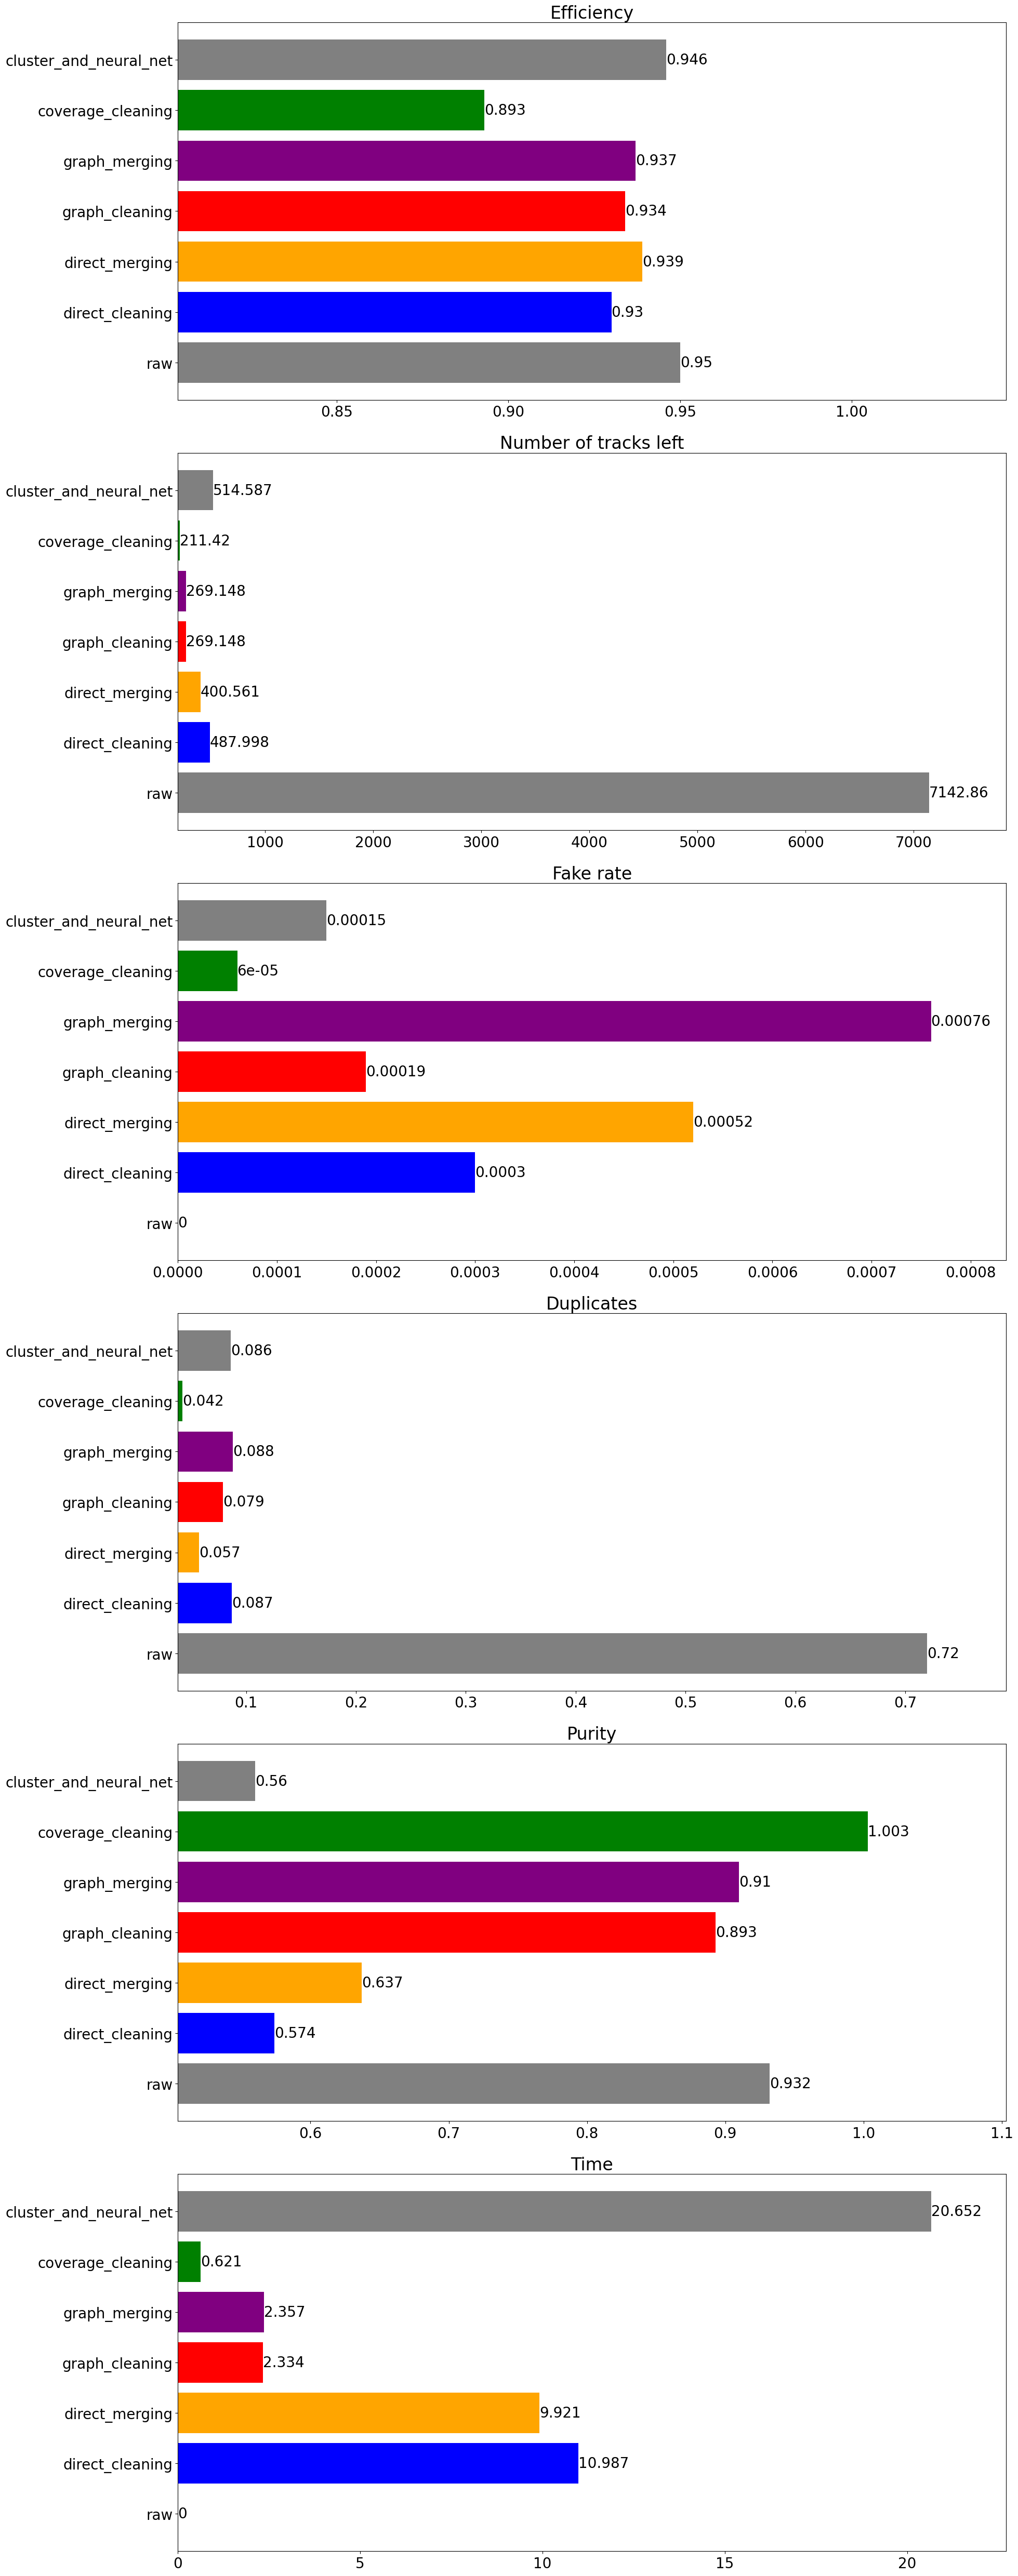

In [40]:
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(6, 1, figsize=(20, 50))
plot_title.append("Time")
colour_list = ['grey', 'blue', 'orange', 'red', 'purple', 'green']
df_list = [df_efficiency, df_num_proto_track, df_fake_rate, df_duplicate, df_purity, df_time]
for plot_id, df in enumerate(df_list):
    bars = axs[plot_id].barh(df.index, df, color=colour_list)
    axs[plot_id].set_title(plot_title[plot_id])
    axs[plot_id].set_xlim(df.min() * 0.9, df.max() * 1.1)
    
    for bars in axs[plot_id].containers:
        axs[plot_id].bar_label(bars)
        

    

plt.tight_layout()
plt.show()